# Chapter 5 인공 신경망

## 5.1 다층 퍼셉트론 Multi-Layer Perceptron, MLP
- 비선형적인 문제를 풀기 위해 활성화 함수와 입력층과 출력층 사이의 은닉층을 추가함

5.1.1 선형 회귀

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

x = torch.FloatTensor(range(5)).unsqueeze(1) # 2차원 데이터로 표현을 위해 unsqueeze(1)
y = 2*x + torch.rand(5,1)

class LinearRegressor(nn.Module):
  def __init__(self):
    super().__init__()
    # 선형 회귀 모델 y=wx+b를 nn.Linear(N,M,bias=True)로 표현할 수 있음
    # N: 입력 변수의 개수 / M: 출력 변수의 개수
    self.fc = nn.Linear(1,1,bias=True)

  # 실제 입력값이 들어와 연산이 진행되는 순서와 방법을 정함
  def forward(self, x):
    y = self.fc(x) # x값을 받아 y값 반환

    return y

model = LinearRegressor()
learning_rate = 1e-3
criterion = nn.MSELoss() # MSE를 손실 함수로 사용
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_stack = []
for epoch in range(1001):

  optimizer.zero_grad()
  y_hat = model(x)
  loss = criterion(y_hat,y)

  loss.backward()
  optimizer.step()
  loss_stack.append(loss.item())

  if epoch % 100 == 0:
    print(f'Epoch {epoch}:{loss.item()}')

Epoch 0:23.308042526245117
Epoch 100:1.7724472284317017
Epoch 200:0.30447834730148315
Epoch 300:0.18897055089473724
Epoch 400:0.16635224223136902
Epoch 500:0.15165558457374573
Epoch 600:0.1389746218919754
Epoch 700:0.12774530053138733
Epoch 800:0.11778169870376587
Epoch 900:0.10893960297107697
Epoch 1000:0.10109265148639679


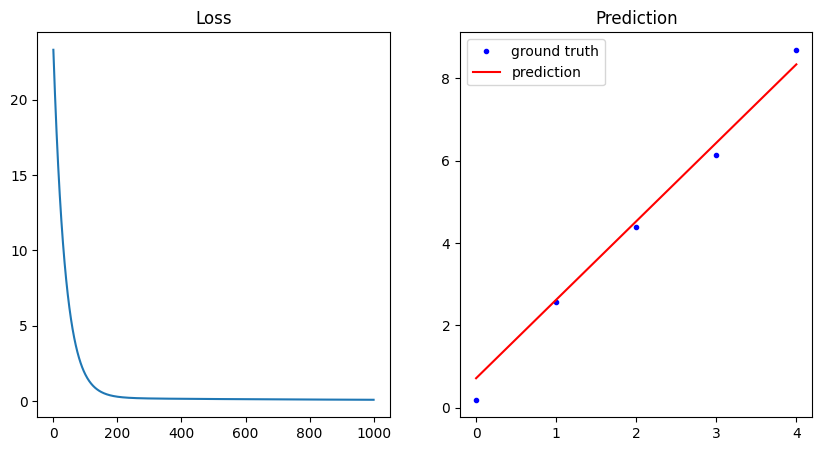

In [2]:
with torch.no_grad(): # 예측은 학습이 아니므로 with torch.no_grad() 를 통해 requires_grad 비활성화
  y_hat = model(x)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")
plt.subplot(122)
plt.plot(x,y,'.b')
plt.plot(x,y_hat,'r-') # - 옵션을 넣어 5개의 점이 이어진 선 형식으로 표현
plt.legend(['ground truth', 'prediction'])
plt.title("Prediction")
plt.show()

### 5.1.2 집값 예측하기
- nn.Linear()를 줄지어 여러 층으로 구성된 깊은 신경망인 다층 신경망을 만든다

In [3]:
# pandas: 데이터 프레임 형태로 다룰 수 있음
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
# Regression 문제의 평가를 위해 RMSE(MSE 척도를 라이브러리를 통해 불러온 후 MSE에 제곱근을 씌운 형태) 사용
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
# 데이터셋 만들기

df = pd.read_csv('./data/reg.csv',index_col=[0]) # csv 파일의 첫 번째 열에 있는 데이터의 인덱스를 배제하고 데이터프레임을 만듦

In [5]:
# 데이터 프레임을 넘파이 배열로 만들기

X = df.drop('Price', axis=1).to_numpy() # df에서 Price를 제외한 나머지를 변수로 사용, 열 기준으로 배제
Y = df['Price'].to_numpy().reshape((-1,1)) # Price를 타겟값 Y로 사용

In [6]:
# 전체 데이터를 50:50으로 학습 데이터와 평가 데이터로 나눔

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [8]:
# 텐서 데이터 만들기
# trainloader, testloader

class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)
testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [9]:
# 모델 구축하기
# Regressor: 입력층 1개, 은닉층 2개, 출력층 1개를 가진 모델
# 데이터 피쳐 개수가 13개이므로 입력층의 노드가 13개, 집값 예측이므로 출력층 1개. (은닉층)이전 층의 출력값과 다음 층의 입력값 크기는 같아야 함.

class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13,50,bias=True) # 입력층 -> 은닉층1
    self.fc2 = nn.Linear(50,30,bias=True) # 은닉층1 -> 은닉층2
    self.fc3 = nn.Linear(30,1,bias=True) # 은닉층2 -> 출력층
    self.dropout = nn.Dropout(0.5) # 연산이 될 때마다 50% 비율로 랜덤하게 노드를 없앰 (forward 함수에서 적용 위치 정해줌)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # 선형 연산 후 ReLU 활성화 함수 적용. 활성화 함수는 층과 층 사이의 관계를 비선형으로 만들 수 있어 성능 향상에 도움이 됨
    x = self.dropout(F.relu(self.fc2(x))) # 30개 중 50% 확률로 값을 0으로 만듦. overfitting을 방지하기 위해 노드의 일부를 배제하고 학습하는 방식이기에 출력층에는 절대로 사용하면 안 됨
    x = F.relu(self.fc3(x)) # 배치가 32개고 출력값이 하나이기 때문에 크기가 torch.Size([32,1])인 결과 뽑아내 반환
    return x

In [10]:
# 모델 학습하기
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-7) # Adam 최적화 방법 정의. weight_decay는 L2 정규화의 penalty 값을 의미하며 값이 클수록 제약조건이 강함

loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 만들기
n = len(trainloader) # 매 epoch 손실 함수값의  평균을 구하기 위해 배치 반복 수 n
for epoch in range(400): # 400번 데이터 반복 학습
  running_loss = 0.0 # 초깃값 0
  for data in trainloader:
    inputs, values = data # 입력값, 타깃값
    optimizer.zero_grad() # gradient 초기화
    outputs = model(inputs) # 모델에 입력값 넣어 예측값 산출
    # 손실 함수값 계산 및 최적화
    loss = criterion(outputs, values)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() # 배치마다 loss를 더함

  loss_.append(running_loss/n) # 저장용 리스트에 매 epoch 결과 저장

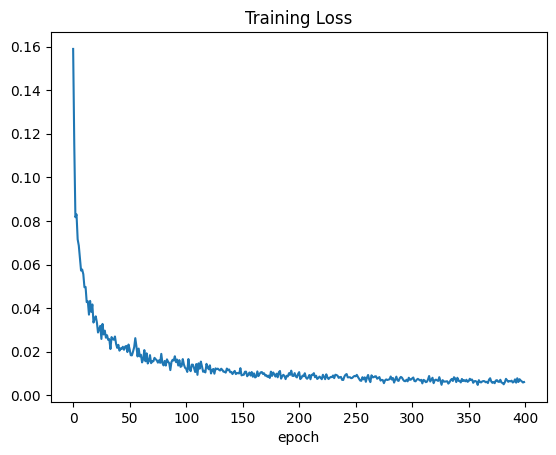

In [11]:
# 손실 함수값 그리기
# 모델의 성능을 판단할 수는 없지만, 학습이 잘 진행되었는지는 파악 가능

plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 5.2 활성화 함수

### 5.2.3 시그모이드(sigmoid) 함수
- 모든 입력값에 대해 0과 1 사이로 변환
- 이진 분류 (0.5 이하면 0, 초과면 1로 변환)

In [ ]:
torch.sigmoid()
nn.Sigmoid()

### 5.2.4 tanh 함수
- 0과 음수값을 가짐 (-1과 1 사이 값을 취함)
- 0 부근에서 sigma보다 더 가파른 기울기를 갖는다

In [ ]:
torch.tanh()
nn.Tanh()

### 5.2.5 ReLU 함수
- 비선형 함수지만 선형과 매우 유사로 최적화 용이

In [ ]:
torch.nn.functional.relu()
nn.ReLU()

### 5.2.6 Softmax 함수
- 벡터 x에 대하여 모든 성분이 항상 양수며, 그 합이 1이 되도록 변환
- 벡터 형태로 예측값이 나오는 다중 분류 문제에서 자주 사용

In [ ]:
torch.nn.functional.softmax()
nn.Softmax()

## 5.3 손실 함수
- 최적화를 하는데 목적 함수가 됨

### 5.3.1 MAE
- 유사도, 거리 측정, 회귀 문제

In [ ]:
torch.nnL1Loss

### 5.3.2 MSE
- MAE와 함께 유사도 거리 측정, 회귀 문제

In [ ]:
torch.nn.MSELoss

### 5.3.3 Cross Entropy Loss
- 다중 분류 문제
- 파이토치에서는 예측값은 벡터 형태, 타깃값은 라벨 형태로 세팅해야 에러가 안 남

In [ ]:
torch.nn.CrossEntropyLoss

## 5.4 최적화 기법
- 경사하강법: 손실 함수를 작게 만드는 것은 경사가 떨어지는 방향으로 가는 것
- 학습률: 경사를 의미하는 미분을 통해 w를 업데이트 하는데, 이때 하강에 대한 보폭을 정해주는 값
- 하이퍼 파라미터 ex) 학습률


### 5.4.1 확률적 경사하강법(SGD)
- 모든 변수의 미분을 계산해 한 번에 갱신하는데, 데이터가 많은 경우 학습 속도가 느려지며 메모리가 부족한 경우가 생기므로, 이를 위해 데이터를 나눠서 학습하는 방법
- 즉, mini-batch를 이용해 경사하강법을 진행하는 것
- '확률적'이라 하는 이뉴는 미니 배치를 나눌 때 데이터를 무작위로 섞어 나누기 때문

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### 5.4.2 다양한 최적화 기법
- 경사하강법과 SGD의 단점은 학습률이 고정되어 있다는 것. 이를 최적화하기 위함이 모멘텀+스케줄링 또는 Adam

In [ ]:
# momentum 방법: SGD 함수에 momentum 지수를 넣어줌

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Adam 방법

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### 5.4.3 스케쥴링
- 가변 학습률을 사용하지 않는 방법에 대해서는 학습률이 변하지 않으므로, 별도로 학습률이 어떻게 바뀌는지 규칙을 정해주는 것을 말함

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size =30, gamma =0.1) # 30번 학습마다 0,1배씩 줄여주려면
... 중략 ...
for epoch in range(400):
    running_loss = 0.0
    for data in trainloader:
      inputs, values = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()
      ... 중략 ...
    scheduler.step()

### 5.4.4 MADGRAD
- 모멘텀과 가변식 방법을 병행하는 최신 최적화 방법으로 SGD와 ADAM을 능가

In [ ]:
madgrad.MADGRAD(모델 변수, lr = 학습률(default: 0.01), momentum = 모멘텀지수(default: 0.9),
                weight_decay = L2페널티(default: 0))

In [ ]:
pip install madgrad # 설치

import madgrad
optimizer = madgrad.MADGRAD(model.parameters())

## 5.5 교차 검증
- k겹 교차 검증 k-Fold Cross-Validation: 학습 데이터를 k개로 나누어 1개는 검증 데이터로 사용, 나머지 k-1개는 학습 데이터로 사용함. 따라서 k번의 검증 과정이 필요하므로 느린 것이 단점

### 5.5.1 교차 검증을 통한 집값 예측 모델 평가

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
# 학습 데이터셋을 k개의 부분 데이터셋(폴드)로 나눈 후, k-1개는 학습 데이터, 나머지 1개는 검증 데이터로
# 사용할 수 있도록 전체 학습 데이터셋에서 인덱스를 나눠주는 역할
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [15]:
# 데이터 프레임을 넘파이 배열로 만들기

df = pd.read_csv('./data/reg.csv', index_col=[0])
X = df.drop('Price', axis=1).to_numpy()
U = df['Price'].to_numpy().reshape((-1,1))

In [17]:
# 텐서 데이터 만들기
# trainset은 교차 검증을 위해 나누기 때문에 미리 DataLoader를 정의하지 않음

class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7)
trainset = TensorData(X_train, Y_train)
testset = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [18]:
# 모델 구축

class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13,50,bias=True)
    self.fc2 = nn.Linear(50,30,bias=True)
    self.fc3 = nn.Linear(30,1,bias=True)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [19]:
# 손실 함수와 교차 검증 정의

kfold = KFold(n_splits=3, shuffle=True) # 학습 데이터를 3개의 폴드로 나눠 3겹 교차 검증 진행
criterion = nn.MSELoss()

In [20]:
# 평가 함수 정의

def evaluation(dataloader):
  # 예측값과 실제값을 저장할 빈 텐서 만들기
  predictions = torch.tensor([], dtype=torch.float)
  actual = torch.tensor([], dtype=torch.float)

  # 평가 시에는 모델 파라미터에 대한 업데이트가 필요 없으므로 비활성화
  with torch.no_grad():
    model.eval() # 평가할 때에는 .eval()을 반드시 사용해야 한다.

    # 데이터를 불러와 예측을 시행하고 예측값과 실제값 저장
    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat을 통해 예측값 누적
      actual = torch.cat((actual, values), 0) # cat을 통해 실제값 누적

  # CPU용 텐서를 넘파이 배열로 변환
  predictions = predictions.numpy()
  actual = actual.numpy()
  # RMSE를 측정하여 성능 평가
  rmse = np.sqrt(mean_squared_error(predictions, actual))
  model.train() # 평가할 때는 .eval(), 즉 평가 시에는 학습 시에 사용하는 기술 비활성화할 것. 학습 시 다시 .train() 사용
  return rmse

In [22]:
# 교차 검증을 이용한 학습 및 평가

validation_loss = [] # 검증 점수를 산출하기 위해 폴드 별 loss 저장 리스트 만듦
for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)): # 나눠진 학습 데이터의 인덱스를 불러옴

    # TensorData로 정의된 데이터의 일부를 불러와 배치 데이터 형태로 활용할 수 있도록 DataLoader와 SubsetRandomSampler 함게 사용
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, sampler = train_subsampler)
    valloader = torch.utils.data.DataLoader(trainset, batch_size =32, sampler = val_subsampler)

    # 매 학습마다 모델 파라미터를 초기화하기 위해 for문 안에 모델 선언
    model = Regressor()
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.01, weight_decay = 1e-7)

    # 데이터 학습
    for epoch in range(400):
        for data in trainloader:
            inputs, values = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, values)
            loss.backward()
            optimizer.step()

    # 각 검증마다 학습 데이터와 검증 데이터를 가지고 RMSE 계산 (총 3번 계산)
    train_rmse = evaluation(trainloader)
    val_rmse = evaluation(valloader)
    print("k-fold", fold, "train loss: %.4f, validation loss: %.4f" % (train_rmse, val_rmse))
    validation_loss.append(val_rmse) # 검증 RMSE 저장

k-fold 0 train loss: 0.1199, validation loss: 0.0939
k-fold 1 train loss: 0.0900, validation loss: 0.1569
k-fold 2 train loss: 0.1177, validation loss: 0.1024


In [23]:
# 검증 점수 산출

validation_loss = np.array(validation_loss)
# 저장된 검증 RMSE의 평균과 표준편차를 구해 출력
mean = np.mean(validation_loss)
std = np.std(validation_loss)
print("Validation Score: %.4f")

Validation Score: %.4f


In [24]:
# 모델 평가

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)
print("Train RMSE: %.4f" %train_rmse)
print("Test RMSE: %.4f" %test_rmse)


Train RMSE: 0.1128
Test RMSE: 0.1333


## 5.6 모델 구조 및 가중치 확인

### 5.6.1 모델 구조

In [25]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary # 구조와 모델 변수를 간략히 알려주는 라이브러리

In [26]:
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13,50) # 가중치 13x50=650개, 편향 50개이므로 총 700개 변수 존재
    self.fc2 = nn.Linear(50,30) # 변수 1530개
    self.fc3 = nn.Linear(30,1) # 변수 31개
    self.dropout = nn.Dropout(0.5)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.relu(self.fc3(x))

    return x

In [27]:
model = Regressor()
print(model)

Regressor(
  (fc1): Linear(in_features=13, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### 5.6.2 모델 변수

In [ ]:
for parameter in model.parameters():
  print(parameter.size())

torch.Size([50, 13])
torch.Size([50])
torch.Size([30, 50])
torch.Size([30])
torch.Size([1, 30])
torch.Size([1])


In [ ]:
print(model.fc1.weight.size(), model.fc1.bias.size())

torch.Size([50, 13]) torch.Size([50])


In [ ]:
for name, param in model.named_parameters():
  print(name, param.size())

fc1.weight torch.Size([50, 13])
fc1.bias torch.Size([50])
fc2.weight torch.Size([30, 50])
fc2.bias torch.Size([30])
fc3.weight torch.Size([1, 30])
fc3.bias torch.Size([1])


In [ ]:
# 층마다 출력값의 크기와 변수에 대한 정보를 테이블로 만들어줌

summary(model, (10,13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 50]             700
            Linear-2               [-1, 10, 30]           1,530
           Dropout-3               [-1, 10, 30]               0
            Linear-4                [-1, 10, 1]              31
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
